In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect
from time import time

import netCDF4
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

sys.path.append('../util')
from ncgen import make_nc
from circle import wkt_circle
from geo import cartesian
from areas import metro_van_10, prov_bc_18, fp_270
from grids import bc_400m, canada_5k, world_125k, world_250k

from shapely import wkt
from shapely.geometry import Point, Polygon, box


os.environ['TMPDIR'] = os.getenv('HOME') + '/tmp/'

In [2]:
def clipLatLonToPolyExtent(lat, lon, poly):
    minx, miny, maxx, maxy = poly.bounds    
    lat = lat[np.where( (lat > miny) & (lat < maxy) )]
    lon = lon[np.where( (lon > minx) & (lon < maxx) )]
    
    return lat, lon

def pointsInPoly(coords, poly):    
    x = [1 if poly.contains(Point(p[0], p[1])) else 0 for p in coords]
    coords = coords[np.where(x)]
    return coords

In [3]:
def polygonToMask(nc, poly):
    nclats = nc.variables['lat'][:]
    nclons = nc.variables['lon'][:]

    mask = np.zeros(nc.variables['var_0'][0,:,:].shape)
    
    lat, lon = clipLatLonToPolyExtent(nclats, nclons, poly)
    
    # If no centroids in polygon, return zeros
    if lat.size == 0 or lon.size == 0:
        return mask

    coords = cartesian([lon, lat])
    pts = pointsInPoly(coords, poly)

    # map the lon, lat values back to numpy indices
    lons = np.sort(np.unique(pts[:,0]))
    lats = np.sort(np.unique(pts[:,1]))
    lon_indices = nclons.searchsorted(lons)
    lat_indices = nclats.searchsorted(lats)

    lat_map = dict(zip(lats, lat_indices))
    lon_map = dict(zip(lons, lon_indices))
    

    for pt in pts:
        mask[lon_map[pt[0]],lat_map[pt[1]]] = 1
        
    return mask

In [4]:
from rtree import index

class GriddedPolygon:
    '''
    This builds a queryable structure for high speed point in polygon operations.
    Based on partitioning the polygon into an n*n grid
    '''
    def __init__(self, poly, size=24):
        assert isinstance(poly, Polygon)
        self.poly = poly
        self.minx, self.miny, self.maxx, self.maxy = poly.bounds
        self.size = size
        self.interior_idx = index.Index()
        self.exterior_idx = index.Index()
        
        self.grid = self._generate_grid()
        self._index_grid()
        
        self.index_hits = 0
        self.lookup_hits = 0

    def _generate_grid(self):
        x_range = np.linspace(self.minx, self.maxx, self.size + 1)
        y_range = np.linspace(self.miny, self.maxy, self.size + 1)
        
        grid = []
        for xi in range(self.size):
            for yi in range(self.size):
                grid.append(box(x_range[xi], y_range[yi], x_range[xi + 1], y_range[yi] + 1))
        return grid

    def _index_grid(self):
        '''
        Both shapely and Rtree use logic that a point on the boundary of an object are not 
        contained within that object. This could lead to points on the boundary of known
        inside/ouside grid cell's being needlessly tested.
        '''
        for i, g in enumerate(self.grid):
            if poly.contains(g):
                self.interior_idx.insert(i, g.bounds)
            elif poly.disjoint(g):
                self.exterior_idx.insert(i, g.bounds)

    def contains(self, p):
        '''
        First test for exerior index, then interior, then edges
        '''
        assert isinstance(p, Point)
        x, y = p.x, p.y

        # Check known interior
        try:
            next(self.interior_idx.intersection((x, y, x, y)))
            self.index_hits += 1
            return True
        except StopIteration:
            pass

        # Check known exterior
        try:
            next(self.exterior_idx.intersection((x, y, x, y)))
            self.index_hits += 1
            return False
        except StopIteration:
            pass

        # Check unknown area        
        self.lookup_hits += 1
        if Point(x, y).within(self.poly):
            return True

        return False

def polygonToMaskGrid(nc, poly):
    # Grid method: http://erich.realtimerendering.com/ptinpoly/
    nclats = nc.variables['lat'][:]
    nclons = nc.variables['lon'][:]

    mask = np.zeros(nc.variables['var_0'][0,:,:].shape)

    lat, lon = clipLatLonToPolyExtent(nclats, nclons, poly)
    
    # If no centroids in polygon, return zeros
    if lat.size == 0 or lon.size == 0:
        return mask

    coords = cartesian([lon, lat])
    grid_poly = GriddedPolygon(poly)
    pts = pointsInPoly(coords, grid_poly)
    print("Index hits: {}, Lookups: {}".format(grid_poly.index_hits, grid_poly.lookup_hits))

    # map the lon, lat values back to numpy indices
    lons = np.sort(np.unique(pts[:,0]))
    lats = np.sort(np.unique(pts[:,1]))
    lon_indices = nclons.searchsorted(lons)
    lat_indices = nclats.searchsorted(lats)

    lat_map = dict(zip(lats, lat_indices))
    lon_map = dict(zip(lons, lon_indices))

    for pt in pts:
        mask[lon_map[pt[0]],lat_map[pt[1]]] = 1

    return mask


In [5]:
def pointInPoly(x, y, poly):
    cell = Point(x, y)
    if poly.contains(cell):
        return True
    else:
        return False

pointsInPolyV = np.vectorize(pointInPoly)

def polygonToMaskSimple(nc, poly):
    nclats = nc.variables['lat'][:]
    nclons = nc.variables['lon'][:]

    # Calculate the polygon extent                                                                                                                      
    minx, miny, maxx, maxy = poly.bounds

    lons = ma.masked_outside(nclons, minx, maxx, copy=False)
    lats = ma.masked_outside(nclats, miny, maxy, copy=False)

    lons, lats = np.meshgrid(lons, lats)
    
    full_mask = lons.mask | lats.mask
    pnp_mask = ~pointsInPolyV(lons[~full_mask], lats[~full_mask], poly)
    full_mask[~full_mask] = pnp_mask

    return ~full_mask


In [6]:
def make_poly(size, center=(-125, 55)):
    x, y = center[0], center[1]
    return Polygon([(x-size, y), (x, y-size), (x+size, y), (x, y+size), (x-size, y)])

In [7]:
results = []
grid_results = []
ma_results = []

areas = [x for x in map(make_poly, [1, 2/1.41, 4/1.41**2, 8/1.41**3, 16/1.41**4, 32/1.41**5])]

with NamedTemporaryFile(suffix='.nc', dir='/app/tmp') as f:
    nc = make_nc(f.name, grid=canada_5k)

    for poly in areas:

        lat, lon = clipLatLonToPolyExtent(nc.variables['lat'][:], nc.variables['lon'][:], poly)
        if lat.size == 0 or lon.size == 0:
            pts_tested = 0
        else:
            pts_tested = len(lon) * len(lat)

        t0 = time()
        mask = polygonToMaskGrid(nc, poly)
        t1 = time()
        t = t1 - t0
        r = ('gridded', pts_tested, np.sum(mask), t)
        print(r)
        grid_results.append(r)

        t0 = time()
        mask = polygonToMask(nc, poly)
        t1 = time()
        t = t1 - t0
        r = ('nogrid', pts_tested, np.sum(mask), t)
        print(r)
        results.append(r)
        
        t0 = time()
        mask = polygonToMaskSimple(nc, poly)
        t1 = time()
        t = t1 - t0
        r = ('simple', pts_tested, np.sum(mask), t)
        print(r)
        ma_results.append(r)

Index hits: 314, Lookups: 262
('gridded', 576, 288.0, 0.13569355010986328)
('nogrid', 576, 288.0, 0.025290489196777344)
('simple', 576, 288, 0.03352761268615723)
Index hits: 791, Lookups: 365
('gridded', 1156, 578.0, 0.21658778190612793)
('nogrid', 1156, 578.0, 0.06032562255859375)
('simple', 1156, 578, 0.06165051460266113)
Index hits: 1824, Lookups: 480
('gridded', 2304, 1152.0, 0.3558928966522217)
('nogrid', 2304, 1152.0, 0.09774208068847656)
('simple', 2304, 1152, 0.10326981544494629)
Index hits: 3655, Lookups: 1037
('gridded', 4692, 2346.0, 0.6326053142547607)
('nogrid', 4692, 2346.0, 0.19218087196350098)
('simple', 4692, 2346, 0.19233989715576172)
Index hits: 8088, Lookups: 1321
('gridded', 9409, 4716.0, 1.121492624282837)
('nogrid', 9409, 4716.0, 0.38709354400634766)
('simple', 9409, 4716, 0.36014771461486816)
Index hits: 15287, Lookups: 3757
('gridded', 19044, 9453.0, 2.65486741065979)
('nogrid', 19044, 9453.0, 0.8140017986297607)
('simple', 19044, 9453, 0.7496538162231445)


In [8]:
gra = np.array([(r[1], r[3]) for r in grid_results])
ra = np.array([(r[1], r[3]) for r in results])
sa = np.array([(r[1], r[3]) for r in ma_results])

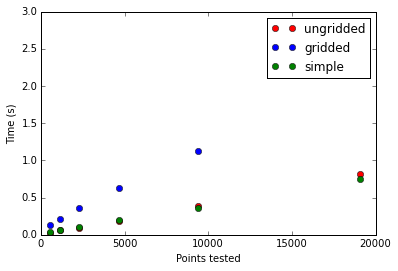

In [9]:
%matplotlib inline
plt.plot(ra[:,0], ra[:,1], 'ro', label="ungridded")
plt.plot(gra[:,0], gra[:,1], 'bo', label="gridded")
plt.plot(sa[:,0], sa[:,1], 'go', label="simple")
plt.legend()

plt.xlabel('Points tested')
plt.ylabel('Time (s)')

In [10]:
import cProfile

In [14]:
cProfile.run("mask = polygonToMaskSimple(nc, poly)", sort='cumtime')

         667421 function calls in 1.024 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.024    1.024 {built-in method exec}
        1    0.001    0.001    1.024    1.024 <string>:1(<module>)
        1    0.002    0.002    1.024    1.024 <ipython-input-5-efbd45b47ddc>:10(polygonToMaskSimple)
        1    0.000    0.000    1.004    1.004 function_base.py:1546(__call__)
        1    0.024    0.024    1.003    1.003 function_base.py:1628(_vectorize_call)
    19045    0.026    0.000    0.916    0.000 <ipython-input-5-efbd45b47ddc>:1(pointInPoly)
    19045    0.035    0.000    0.570    0.000 base.py:623(contains)
    19045    0.435    0.000    0.531    0.000 predicates.py:11(__call__)
    19045    0.023    0.000    0.320    0.000 point.py:37(__init__)
    19045    0.037    0.000    0.295    0.000 point.py:124(_set_coords)
    19045    0.167    0.000    0.210    0.000 point.py:188(geos_point_from

In [15]:
cProfile.run("mask = polygonToMask(nc, poly)", sort='cumtime')

         647756 function calls (647755 primitive calls) in 1.021 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.021    1.021 {built-in method exec}
        1    0.000    0.000    1.021    1.021 <string>:1(<module>)
        1    0.009    0.009    1.021    1.021 <ipython-input-3-dc25b7acb7a6>:1(polygonToMask)
        1    0.000    0.000    1.009    1.009 <ipython-input-2-b8229ec3be2d>:8(pointsInPoly)
        1    0.057    0.057    1.007    1.007 <ipython-input-2-b8229ec3be2d>:9(<listcomp>)
    19044    0.034    0.000    0.568    0.000 base.py:623(contains)
    19044    0.435    0.000    0.529    0.000 predicates.py:11(__call__)
    19044    0.024    0.000    0.322    0.000 point.py:37(__init__)
    19044    0.038    0.000    0.296    0.000 point.py:124(_set_coords)
    19044    0.171    0.000    0.214    0.000 point.py:188(geos_point_from_py)
    38092    0.023    0.000    0.085    0.000 to

In [16]:
cProfile.run("mask = polygonToMaskGrid(nc, poly)", sort='cumtime')

Index hits: 15287, Lookups: 3757
         2036567 function calls (2036566 primitive calls) in 3.160 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.160    3.160 {built-in method exec}
        1    0.000    0.000    3.160    3.160 <string>:1(<module>)
        1    0.010    0.010    3.158    3.158 <ipython-input-4-51402b1509c6>:74(polygonToMaskGrid)
        1    0.000    0.000    2.983    2.983 <ipython-input-2-b8229ec3be2d>:8(pointsInPoly)
        1    0.077    0.077    2.981    2.981 <ipython-input-2-b8229ec3be2d>:9(<listcomp>)
    19044    0.118    0.000    2.452    0.000 <ipython-input-4-51402b1509c6>:44(contains)
    30371    0.454    0.000    1.000    0.000 index.py:403(intersection)
    38088    0.206    0.000    0.475    0.000 coords.py:90(__getitem__)
    22801    0.037    0.000    0.452    0.000 point.py:37(__init__)
    19044    0.034    0.000    0.445    0.000 point.py:53(x)
    